In [1]:
# -*- coding:utf-8 -*-
import poloniex
import time
import json

# poloniex API
polo = poloniex.Poloniex()
# 2017/12/12 AM 12:00 @JP
unix_time = 1514646000

#4h間隔で過去180日分 UNIX時間で取得  #14400
chart_data_btc = polo.returnChartData('USDT_BTC', period=1800, start=unix_time-polo.DAY*180, end=unix_time)
chart_data_eth = polo.returnChartData('USDT_ETH', period=14400, start=unix_time-polo.DAY*180, end=unix_time)


In [2]:
import pandas as pd

# DataFrameに変換
df_btc = pd.DataFrame(chart_data_btc)
df_btc.tail(10)

,close,date,high,low,open,quoteVolume,volume,weightedAverage
8631,12911.32692521,1514629800,13099.84257298,12800,12864.64912148,217.22647059,2819431.476574,12979.22609945
8632,13118.00000204,1514631600,13236.37827405,12800.989,12920.8733577,127.66632019,1666040.0808439,13049.95772075
8633,13154.86175661,1514633400,13199.99999999,13032.99999999,13118.00000207,85.35921804,1121476.468819,13138.31703909
8634,12829.05888498,1514635200,13183.34433578,12750,13154.86175664,286.80356893,3689396.3512835,12863.84393697
8635,12510.59512917,1514637000,12829.05888496,12326.00100001,12829.05888494,459.50934795,5748293.7782511,12509.63403442
8636,12134.60110314,1514638800,12545,11855,12510.59512921,749.23015729,9080794.3687079,12120.1666542
8637,12321.58013364,1514640600,12425.14591135,12001,12193.54982702,307.76545967,3772743.2298264,12258.50111273
8638,12158.49021791,1514642400,12600,12156.07143669,12335.99999993,327.51571832,4062792.5507254,12404.87806681
8639,12275.88607229,1514644200,12387.3154709,11922,12158.49021789,389.88321872,4708832.7799357,12077.54669563
8640,12350,1514646000,12498,12209.79105529,12285.59749515,166.61063278,2054090.6672983,12328.68894994


In [3]:
import numpy as np
np.random.seed(1)

# 正規化
data_btc = pd.DataFrame([float(i.get('close')) for i in chart_data_btc])

In [4]:
data_btc = np.array(data_btc.astype(np.float32))
data_btc = np.log(data_btc)

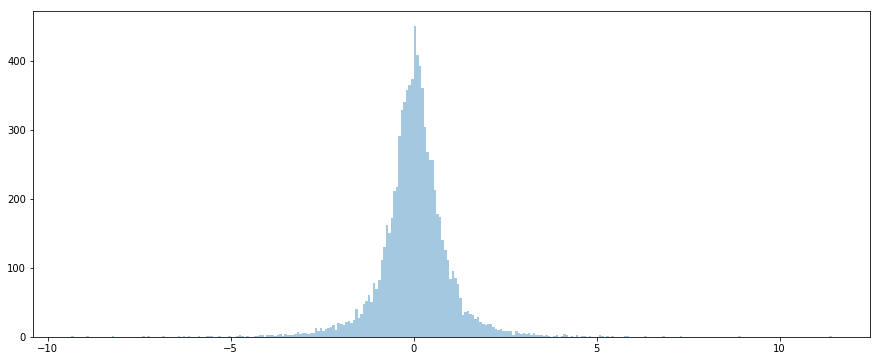

In [5]:
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 15, 6
import matplotlib.pyplot as plt

#前日との差
diff_btc = data_btc[1:] - data_btc[:-1]
diff_btc *= 100
sns.distplot(diff_btc, bins=300, kde=False)
plt.show()

In [6]:
np.exp(0.995/100)

1.0099996658383554

In [7]:
# 標準偏差
diff_std = np.std(diff_btc)
diff_avg = np.average(diff_btc)
print(diff_avg)
# 
print("前日比")
print("標準偏差[%]:{:.2f}".format(np.exp(diff_std/100)*100))
print("平均[%]:{:.2f}".format(np.exp(diff_avg/100)*100))

0.0182952
前日比
標準偏差[%]:100.98
平均[%]:100.02


In [8]:
from sklearn.preprocessing import MinMaxScaler
mss = MinMaxScaler()
data_btc = pd.DataFrame(mss.fit_transform(data_btc))
data_btc = data_btc[0].astype(np.float32)

In [9]:
# onehotラベル生成　
_t_btc = np.empty((len(data_btc),4),dtype=np.float64)
thresh = diff_std
print(thresh)
for i in range(1,len(data_btc)):
    # めっちゃ上がる
    if diff_btc[i-1] >= thresh:  
        _t_btc[i] = np.array([1,0,0,0])
    # 上がる
    elif diff_btc[i-1] >= 0 and diff_btc[i-1] < thresh: 
        _t_btc[i] = np.array([0,1,0,0])
    # 下がる
    elif diff_btc[i-1] >= -thresh and  diff_btc[i-1] < 0: 
        _t_btc[i] = np.array([0,0,1,0])
    # めっちゃ下がる
    else : 
        _t_btc[i] = np.array([0,0,0,1])

0.976343


In [10]:
# データを入力変数xと出力変数tに切り分け
x_btc, t_btc= [], []

N = len(data_btc)
M = 30 # 入力変数の数：直近30サンプルを使用
for n in range(M, N):
 # 入力変数と出力変数の切り分け
 _x = data_btc[n-M: n] # 入力変数
 _t = _t_btc[n] # 出力変数
 # 計算用のリスト(x, t)に追加していく
 x_btc.append(_x)
 t_btc.append(_t)


In [11]:
# numpyに変換
# x.shape : 1050,30 t.shape : 1050,1
x_btc = np.array(x_btc)
t_btc = np.array(t_btc)
x_btc = x_btc.reshape(x_btc.shape[0], x_btc.shape[1], 1)
N_train = int(len(x_btc) * 0.9)
x_train, x_test = x_btc[:N_train], x_btc[N_train:]
t_train, t_test = t_btc[:N_train], t_btc[N_train:]

In [12]:
# model
# 4分類
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

length_of_sequence = x_btc.shape[1] # 30 = M
n_in = x_btc.shape[2]   # 学習データ（＝入力）の列数
n_out = t_btc.shape[1]  # ラベルデータ（=出力）の列数

in_out_neurons = 1
# n_hidden: 出力次元
n_hidden = 30
model = Sequential()
# return_sequenceとは、TrueにしてRNNレイヤーの毎時刻の出力を得るか、Falseにして最後の時刻のみの出力を得るか、のフラグ
# batch_iuput_shape: ([バッチサイズ，step数，特徴の次元数])
model.add(LSTM(units=n_hidden,
               batch_input_shape=(None, length_of_sequence, n_in), 
               return_sequences=False
              ))
model.add(Dropout(0.5))
model.add(Dense(n_out))
model.add(Activation("softmax"))
optimizer = Adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics = ['categorical_accuracy'])

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 124       
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 3,964
Trainable params: 3,964
Non-trainable params: 0
_________________________________________________________________


In [13]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
model.fit(x_train, t_train,
          batch_size=20,
          epochs=30,
          validation_split=0.1,
          shuffle=True,
          callbacks=[early_stopping]
          )

Train on 6974 samples, validate on 775 samples
Epoch 1/30
6974/6974 [==============================] - 31s - loss: 1.1577 - categorical_accuracy: 0.4236 - val_loss: 1.5646 - val_categorical_accuracy: 0.3587
Epoch 2/30
6974/6974 [==============================] - 33s - loss: 1.1269 - categorical_accuracy: 0.4300 - val_loss: 1.5602 - val_categorical_accuracy: 0.3587
Epoch 3/30
6974/6974 [==============================] - 30s - loss: 1.1270 - categorical_accuracy: 0.4279 - val_loss: 1.5544 - val_categorical_accuracy: 0.3587
Epoch 4/30
6974/6974 [==============================] - 29s - loss: 1.1242 - categorical_accuracy: 0.4310 - val_loss: 1.5734 - val_categorical_accuracy: 0.3587
Epoch 5/30
6974/6974 [==============================] - 30s - loss: 1.1222 - categorical_accuracy: 0.4323 - val_loss: 1.5602 - val_categorical_accuracy: 0.3587
Epoch 6/30
6974/6974 [==============================] - 29s - loss: 1.1233 - categorical_accuracy: 0.4345 - val_loss: 1.5724 - val_categorical_accuracy: 

In [14]:
# 正答率、準正答率（騰落）集計
preds = model.predict(x_test)
correct = 0
semi_correct = 0
for i in range(len(preds)):
  pred = np.argmax(preds[i,:])
  tar = np.argmax(t_test[i,:])
  if pred == tar :
    # 純粋な正解率
    correct += 1
  else :
    # 上下は当たってるやつ
    if pred+tar == 1 or pred+tar == 5 : 
      semi_correct += 1

print("正答率:", 1.0 * correct / len(preds))
print("準正答率（騰落）:", 1.0 * (correct+semi_correct) / len(preds))

正答率: 0.3190255220417633
準正答率（騰落）: 0.5174013921113689
